# Challenge Credit Risk

**Packages**

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#from datetime import date, datetime

In [3]:
#plt.rcParams['figure.figsize'] = [8,5]
#plt.rcParams['font.size'] =14
#plt.rcParams['font.weight']= 'bold'
#plt.style.use('seaborn-whitegrid')

## Business Undestanding

### Questions to answer 

- Pick the best clients you will give a loan to, based on the model you created. It
could be as complex as you decide (even as simpler as knock out rules), as long as
the metrics support it
- Propose an amount to be lended to those clients and a term in which the loan will
need to be paid back.
- Finally choose an anual interest rate the lended amount must have in order to be
profitable.

## Data Understanding

Read datasets

In [4]:
from pathlib import Path
root_dir = Path().resolve()

In [5]:
data_users = pd.read_csv('data/users.csv')
data_credit_reports = pd.read_csv('data/credit_reports.csv', parse_dates=['account_opening_date', 'account_closing_date'])

### Solving the date's format
The dataset `data_credit_reports` has '0000-00-00' values in the column `worst_delinquency_date`, probably due to an error in the date's conversion during the data preparation.

In [6]:
data_credit_reports['worst_delinquency_date'].loc[data_credit_reports['worst_delinquency_date'].str.match('.*\/.*\/.*') == False]

16       0000-00-00
22       0000-00-00
23       0000-00-00
354      0000-00-00
355      0000-00-00
            ...    
15642    0000-00-00
15884    0000-00-00
15885    0000-00-00
15898    0000-00-00
15899    0000-00-00
Name: worst_delinquency_date, Length: 428, dtype: object

In [7]:
data_credit_reports['worst_delinquency_date'].replace({"0000-00-00": np.NaN}, inplace=True)
data_credit_reports['worst_delinquency_date'] = pd.to_datetime(data_credit_reports['worst_delinquency_date'], 
                                                              format='%m/%d/%y')

### Exploring user's Income and outcome 

In [8]:
data_users.head(10)

,id,monthly_income,monthly_outcome,class
0,0,255359,151439,1
1,1,8940,789,0
2,2,11436,3316,0
3,3,17143,47547,1
4,4,26990,15585,1
5,5,166,5240,0
6,6,111662,108374,1
7,7,6271,44469,1
8,8,31695,3021,0
9,9,2401260,6496313,0


In [9]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               1000 non-null   int64
 1   monthly_income   1000 non-null   int64
 2   monthly_outcome  1000 non-null   int64
 3   class            1000 non-null   int64
dtypes: int64(4)
memory usage: 31.4 KB


#### Distribution of user's Income and outcome 

In [10]:
data_users.describe()

,id,monthly_income,monthly_outcome,class
count,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,499.500000,1.216138e+05,1.249657e+05,0.535000
std,288.819436,4.709416e+05,5.796281e+05,0.499023
min,0.000000,1.000000e+00,1.000000e+00,0.000000
25%,249.750000,2.691250e+03,3.397750e+03,0.000000
50%,499.500000,1.253350e+04,1.424250e+04,1.000000
75%,749.250000,5.868600e+04,5.722850e+04,1.000000
max,999.000000,9.344842e+06,9.749651e+06,1.000000


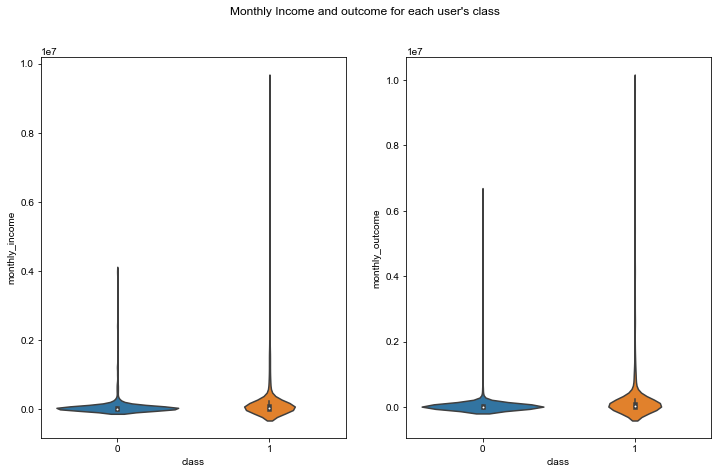

In [11]:
# Set up the matplotlib figure
sns.set_palette("tab10")
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)
fig.suptitle("Monthly Income and outcome for each user's class")

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_income', data=data_users, showfliers=True, ax=axes[0])
#plt.show()

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_outcome', data=data_users, showfliers=True, ax=axes[1])
#plt.show()

#axes1, axes2 = axes.ravel()
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 

#plt.setp(axes, yticks=[])
#plt.tight_layout()
sns.set_style("darkgrid")
fig.savefig("plots/01_datauser_skewed.png")

If we calculate the Fisher-Pearson standardized moment coefficient, we can see that all the variables are skewed

In [12]:
data_users[['monthly_income', 'monthly_outcome']].skew().sort_values(ascending=False)

monthly_outcome    10.895201
monthly_income     10.634858
dtype: float64

The distribution of the `monthly_income` and `monthly_outcome` variable are skewed to high values. There are some outliers.

#### Amount of each class

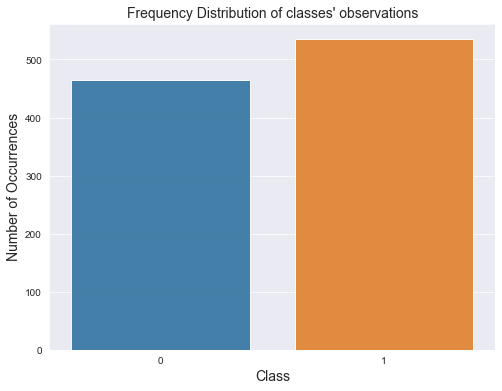

In [13]:
plt.figure(figsize=(8, 6))
class_count = pd.DataFrame(data_users['class'].value_counts())
#sns.set(style="darkgrid")
p1 = sns.barplot(x=class_count.index, y=class_count['class'],  data=class_count, alpha=0.9)
plt.title("Frequency Distribution of classes' observations", fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Class', fontsize=14)
sns.set_style("darkgrid")

fig = p1.get_figure()
fig.savefig("plots/02_datauser_frequency_classes.png")
#plt.show()

The number of observation in each class are balanced. There isn't an important difference between both classes. 

### Exploring user's credit reports

In [14]:
data_credit_reports.head(10)

,user_id,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
0,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,78.0,Semanal,0.0,2014-11-10,2015-12-05,9826.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
1,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,80.0,Semanal,0.0,2015-12-05,2016-10-14,16000.0,0.0,0.0,0.0,3.0,1.0,2016-05-28,200.0
2,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,102.0,Semanal,100.0,2016-09-02,NaT,10205.0,3505.0,0.0,0.0,3.0,1.0,2017-03-03,100.0
3,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,120.0,Semanal,191.0,2016-10-14,NaT,22920.0,11269.0,0.0,0.0,3.0,1.0,2017-03-03,191.0
4,0,KONFIO,Pagos Fijos,Préstamo Personal,12.0,Quincenal,0.0,2016-12-27,2017-06-27,150000.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
5,0,KONFIO,Pagos Fijos,Préstamo Personal,26.0,Quincenal,10825.0,2017-06-28,NaT,225000.0,159142.0,0.0,0.0,0.0,0.0,NaT,0.0
6,0,TELEFONIA CELULAR,Revolvente,Línea de Crédito,1000.0,Mensual,0.0,2016-10-06,2017-09-15,0.0,0.0,999.0,0.0,7.0,4.0,2017-05-31,4342.0
7,0,MERCANCIA PARA HOGAR Y OFICINA,Sin Límite Preestablecido,Crédito Personal al Consumo,0.0,Semanal,0.0,2014-11-10,NaT,0.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
8,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,72.0,Mensual,5874.0,2017-08-22,NaT,513069.0,475245.0,513069.0,0.0,0.0,0.0,NaT,0.0
9,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,24.0,Mensual,10557.0,2017-01-31,NaT,247705.0,124316.0,247705.0,0.0,0.0,0.0,NaT,0.0


In [15]:
data_credit_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   user_id                             16309 non-null  int64         
 1   institution                         16309 non-null  object        
 2   account_type                        16309 non-null  object        
 3   credit_type                         16309 non-null  object        
 4   total_credit_payments               16268 non-null  float64       
 5   payment_frequency                   16308 non-null  object        
 6   amount_to_pay_next_payment          16304 non-null  float64       
 7   account_opening_date                16309 non-null  datetime64[ns]
 8   account_closing_date                9068 non-null   datetime64[ns]
 9   maximum_credit_amount               16307 non-null  float64       
 10  current_balance       

In [16]:
data_credit_reports.describe()

,user_id,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,16309.000000,16268.000000,1.630400e+04,1.630700e+04,1.630400e+04,1.629600e+04,1.630400e+04,16297.000000,16255.000000,1.629700e+04
mean,474.067631,22.405766,2.779242e+03,3.994739e+04,1.993377e+04,2.398115e+04,3.618910e+03,2.291219,1.541618,1.617189e+03
std,293.165091,77.413143,2.145046e+04,1.337402e+05,1.067213e+05,9.429967e+04,2.816734e+04,8.250868,6.816558,2.845180e+04
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,213.000000,0.000000,0.000000e+00,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,466.000000,1.000000,0.000000e+00,6.899000e+03,0.000000e+00,8.925000e+02,0.000000e+00,0.000000,0.000000,0.000000e+00
75%,726.000000,16.000000,5.830000e+02,2.634750e+04,3.224250e+03,1.440600e+04,0.000000e+00,0.000000,0.000000,0.000000e+00
max,999.000000,1800.000000,1.263964e+06,4.883200e+06,4.697583e+06,3.269355e+06,1.915973e+06,96.000000,84.000000,3.234351e+06


#### Missing Values

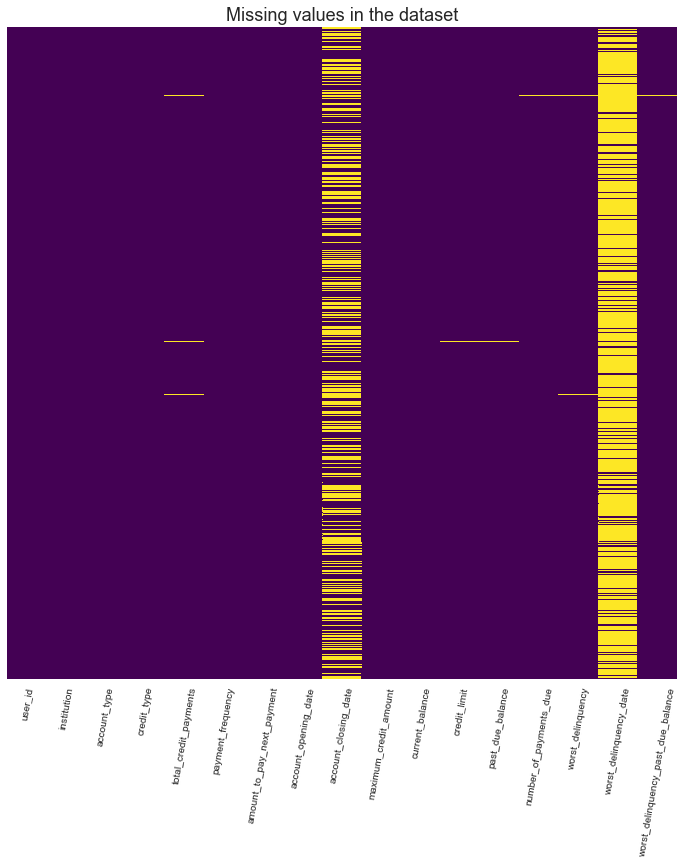

In [17]:
plt.figure(figsize=(12, 12))
p1 = sns.heatmap(data_credit_reports.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.xticks(rotation=80) 
plt.title('Missing values in the dataset', fontsize=18)
plt.margins(0.2)
fig = p1.get_figure()
fig.savefig("plots/03_datacredit_reports_missing_values.png")
plt.show()

We can see that the `account_closing_date` and `worst_delinquency_date` variables have a lot of missing values.

#### Categorical variables

In [18]:
data_credit_reports.describe(include=['object', 'bool'])

,institution,account_type,credit_type,payment_frequency
count,16309,16309,16309,16308
unique,54,8,26,10
top,BANCO,Pagos Fijos,Préstamo Personal,Mensual
freq,4285,8083,5717,11191


In [19]:
institution_count = pd.DataFrame(data_credit_reports['institution'].value_counts())
institution_count = institution_count.reset_index()

account_type_count = pd.DataFrame(data_credit_reports['account_type'].value_counts())
account_type_count = account_type_count.reset_index()

credit_type_count = pd.DataFrame(data_credit_reports['credit_type'].value_counts())
credit_type_count = credit_type_count.reset_index()

payment_frequency_count = pd.DataFrame(data_credit_reports['payment_frequency'].value_counts())
payment_frequency_count = payment_frequency_count.reset_index()

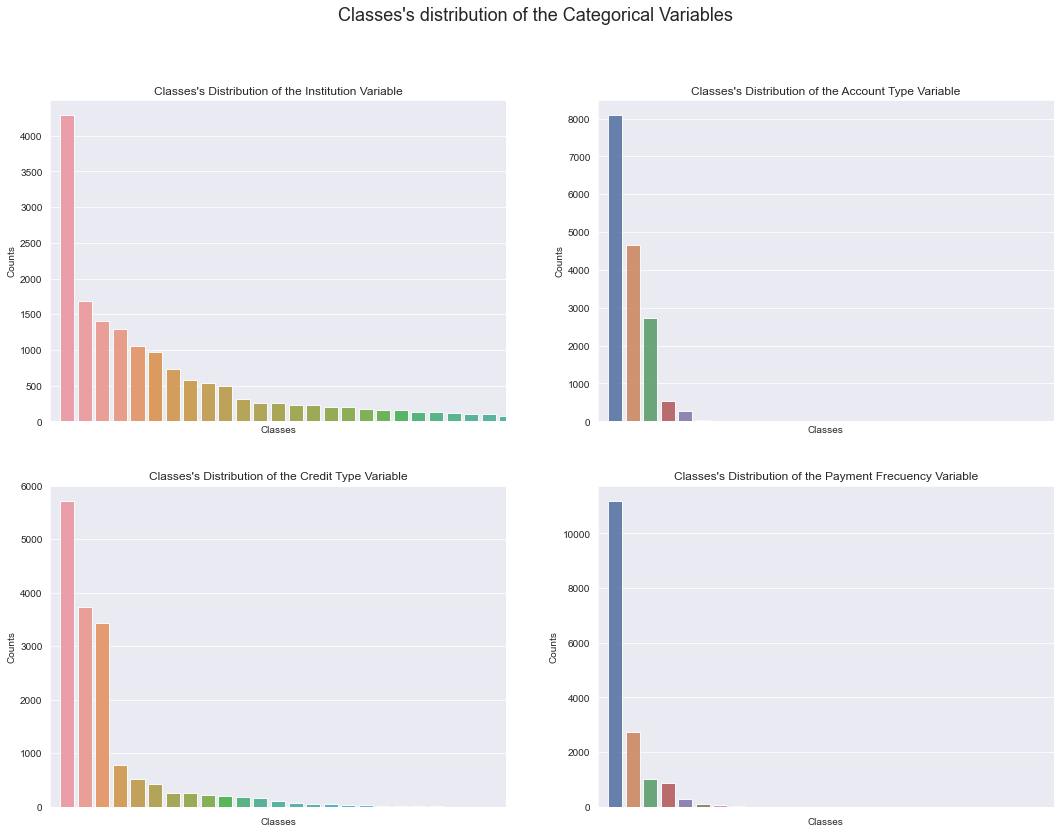

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(18, 13), sharex=True)
fig.suptitle("Classes's distribution of the Categorical Variables", size=18)

sns.set(style="darkgrid")

p1 = sns.barplot(x=institution_count['index'], y='institution',  data=institution_count, alpha=0.9, ax=axes[0,0])
#p1.set(xlabel=None)
p1.set(xticklabels=[])  
p1.set(xlabel='Classes', ylabel='Counts')
p1.set(title="Classes's Distribution of the Institution Variable")

p2 = sns.barplot(x=account_type_count['index'], y='account_type',  data=account_type_count, alpha=0.9, ax=axes[0,1])
p2.set(xticklabels=[])
p2.set(xlabel='Classes', ylabel='Counts')
p2.set(title="Classes's Distribution of the Account Type Variable")

p3 = sns.barplot(x=credit_type_count['index'], y='credit_type',  data=credit_type_count, alpha=0.9, ax=axes[1,0])
p3.set(xticklabels=[])
p3.set(xlabel='Classes', ylabel='Counts')
p3.set(title="Classes's Distribution of the Credit Type Variable")

p4 = sns.barplot(x=payment_frequency_count['index'], y='payment_frequency',  data=payment_frequency_count, alpha=0.9, ax=axes[1,1])
p4.set(xticklabels=[])  
p4.set(xlabel='Classes', ylabel='Counts')
p4.set(title="Classes's Distribution of the Payment Frecuency Variable")

axes1, axes2, axes3, axes4 = axes.ravel()
axes1.set_xlim(-1, 25)
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 
#plt.set(xlabel=None)

#plt.setp(axes, yticks=[])
#plt.tight_layout()
#fig = p1.get_figure()
fig.savefig("plots/04_datacredit_reports_distribution_classes.png")
plt.show()

There is a problem of High cardinality and imbalanced classes, specially in the `institution`, `account_type` and `payment_frecuency` variables.

#### Quantitative variables

<ipython-input-21-a63a6d9f278a>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_credit_reports[["total_credit_payments",


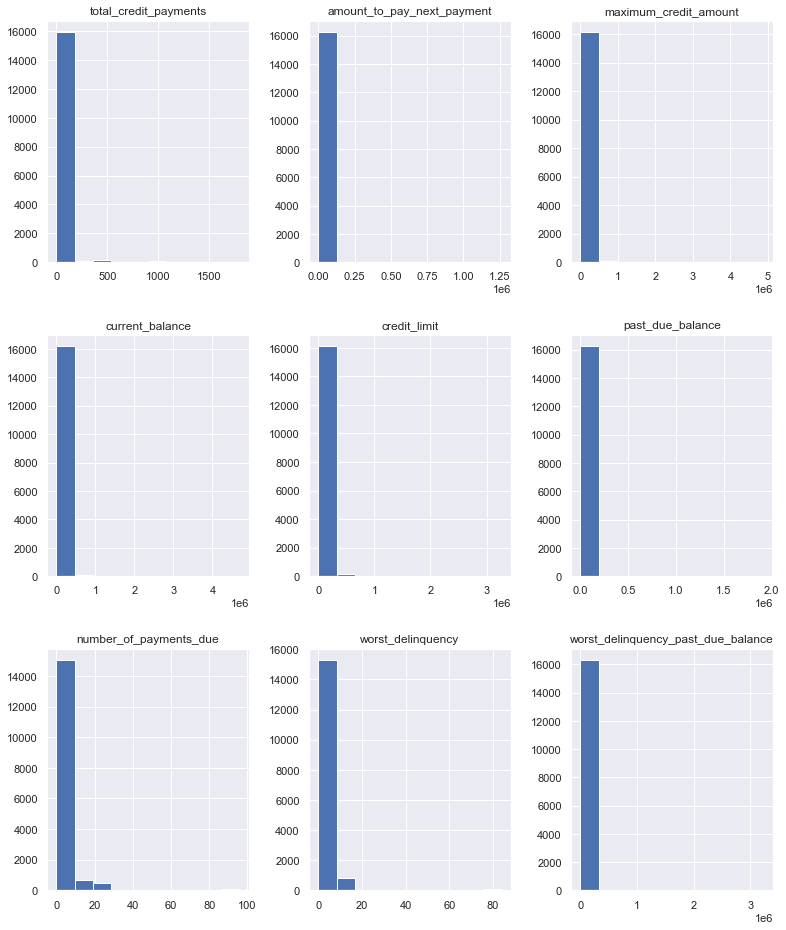

In [21]:
fig = plt.figure(figsize = (13,16))
ax = fig.gca()
#df.hist(ax = ax)

data_credit_reports[["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]].hist(ax=ax)


#fig = p1.get_figure()
fig.savefig("plots/05_datacredit_reports_quantitative_variables_distribution.png")
plt.show()

If we calculate the Fisher-Pearson standardized moment coefficient, we can see that all the variables are skewed

In [22]:
variables = ["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]

data_credit_reports[variables].skew().sort_values(ascending=False)

worst_delinquency_past_due_balance    92.203928
past_due_balance                      29.371754
amount_to_pay_next_payment            28.750662
current_balance                       17.921639
credit_limit                          15.164412
maximum_credit_amount                 13.563707
total_credit_payments                  9.638661
worst_delinquency                      8.683708
number_of_payments_due                 7.244236
dtype: float64

## Data Preparation

In [23]:
#data1 = data_users.copy()
#data2 = data_credit_reports.copy()

### Remove the columns with a high amount of missing values

The variables with a high number of missing values won't provided enough information to the model

In [24]:
mask = data_credit_reports.isna().sum() / len(data_credit_reports) < 0.3
data_credit_reports = data_credit_reports.loc[:, mask]

### Remove Missing Values

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class CreditReportsImputer(BaseEstimator, TransformerMixin):
    # it is used by BaseEstimator
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        imputer2 = SimpleImputer(strategy="median")
        X['total_credit_payments'] = imputer.fit_transform(X[['total_credit_payments']])
        X['amount_to_pay_next_payment'] = imputer.fit_transform(X[['amount_to_pay_next_payment']])
        X['maximum_credit_amount'] = imputer.fit_transform(X[['maximum_credit_amount']])
        X['current_balance'] = imputer.fit_transform(X[['current_balance']])
        X['credit_limit'] = imputer.fit_transform(X[['credit_limit']])
        X['past_due_balance'] = imputer.fit_transform(X[['past_due_balance']])
        X['number_of_payments_due'] = imputer.fit_transform(X[['number_of_payments_due']])
        X['worst_delinquency'] = imputer2.fit_transform(X[['worst_delinquency']])
        X['worst_delinquency_past_due_balance'] = imputer.fit_transform(X[['worst_delinquency_past_due_balance']])
        return X

In [26]:
from sklearn.pipeline import Pipeline
pipeline_na_values = Pipeline([('creditreporstimputer', CreditReportsImputer())])

In [27]:
data_credit_reports = pipeline_na_values.fit_transform(data_credit_reports)

### Treating categorical variables in `data_credit_reports`

There are a high number of classes in the categorical variables, and many of them don't provide us with enough information because of their low number of observations. For this reason, it is a better option to group the classes with low frequency in an unique class.

Furthermore, having a lot of classes in the categorical variables could cause having the heaviest data set after encoding them. Finally, if we use One-Hot encoding the variables could end up being too many (The Curse of Dimensionality). 

In [28]:
def createDataToNewColumn(values_to_scan, classes):
    data_to_new_column = list()
    for i in values_to_scan:
        if ((i == classes).any()):
            data_to_new_column.append(i)
        else:
            data_to_new_column.append('Other')
    return data_to_new_column

Group the classes of the variable `institution`

In [29]:
classes = institution_count[institution_count.institution > institution_count.institution.quantile(0.80)]['index']#.sum()
new_column = createDataToNewColumn(data_credit_reports['institution'], classes)
data_credit_reports.insert(1, 'institution_mod', new_column, True)
data_credit_reports.drop(['institution'], axis=1, inplace=True)

Group the classes of the variable `account_type`

In [30]:
classes = account_type_count[account_type_count.account_type > account_type_count.account_type.quantile(0.75)]['index']#.sum()
new_column = createDataToNewColumn(data_credit_reports['account_type'], classes)
data_credit_reports.insert(2, 'account_type_mod', new_column, True)
data_credit_reports.drop(['account_type'], axis=1, inplace=True)

Group the classes of the variable `credit_type`

In [31]:
classes = credit_type_count[credit_type_count.credit_type > credit_type_count.credit_type.quantile(0.9)]['index']#.sum()
new_column = createDataToNewColumn(data_credit_reports['credit_type'], classes)
data_credit_reports.insert(3, 'credit_type_mod', new_column, True)
data_credit_reports.drop(['credit_type'], axis=1, inplace=True)

Group the classes of the variable `payment_frequency`

In [32]:
classes = payment_frequency_count[payment_frequency_count.payment_frequency > payment_frequency_count.payment_frequency.quantile(0.9)]['index']#.sum()
new_column = createDataToNewColumn(data_credit_reports['payment_frequency'], classes)
data_credit_reports.insert(5, 'payment_frequency_mod', new_column, True)
data_credit_reports.drop(['payment_frequency'], axis=1, inplace=True)

#### New distributions

In [33]:
institution_count = pd.DataFrame(data_credit_reports['institution_mod'].value_counts())
institution_count = institution_count.reset_index()

account_type_count = pd.DataFrame(data_credit_reports['account_type_mod'].value_counts())
account_type_count = account_type_count.reset_index()

credit_type_count = pd.DataFrame(data_credit_reports['credit_type_mod'].value_counts())
credit_type_count = credit_type_count.reset_index()

payment_frequency_count = pd.DataFrame(data_credit_reports['payment_frequency_mod'].value_counts())
payment_frequency_count = payment_frequency_count.reset_index()

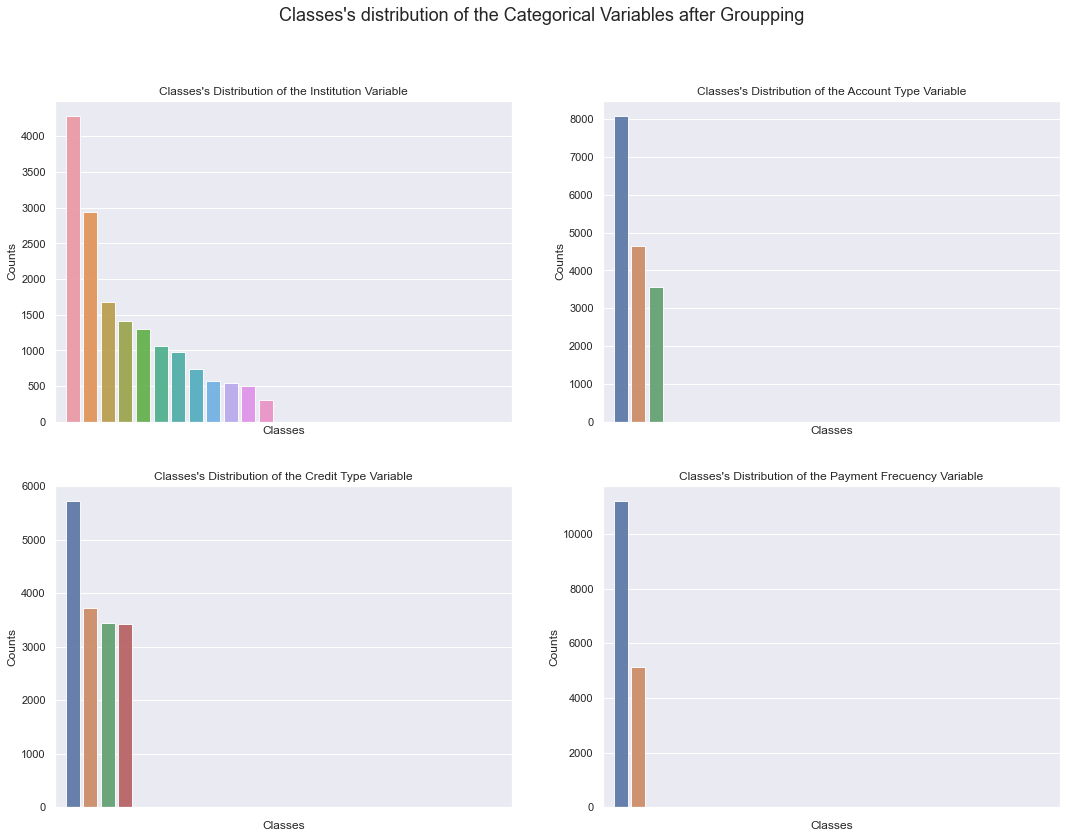

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(18, 13), sharex=True)
fig.suptitle("Classes's distribution of the Categorical Variables after Groupping", size=18)

sns.set(style="darkgrid")

p1 = sns.barplot(x=institution_count['index'], y='institution_mod',  data=institution_count, alpha=0.9, ax=axes[0,0])
#p1.set(xlabel=None)
p1.set(xticklabels=[])  
p1.set(xlabel='Classes', ylabel='Counts')
p1.set(title="Classes's Distribution of the Institution Variable")

p2 = sns.barplot(x=account_type_count['index'], y='account_type_mod',  data=account_type_count, alpha=0.9, ax=axes[0,1])
p2.set(xticklabels=[])
p2.set(xlabel='Classes', ylabel='Counts')
p2.set(title="Classes's Distribution of the Account Type Variable")

p3 = sns.barplot(x=credit_type_count['index'], y='credit_type_mod',  data=credit_type_count, alpha=0.9, ax=axes[1,0])
p3.set(xticklabels=[])
p3.set(xlabel='Classes', ylabel='Counts')
p3.set(title="Classes's Distribution of the Credit Type Variable")

p4 = sns.barplot(x=payment_frequency_count['index'], y='payment_frequency_mod',  data=payment_frequency_count, alpha=0.9, ax=axes[1,1])
p4.set(xticklabels=[])  
p4.set(xlabel='Classes', ylabel='Counts')
p4.set(title="Classes's Distribution of the Payment Frecuency Variable")

axes1, axes2, axes3, axes4 = axes.ravel()
axes1.set_xlim(-1, 25)
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 
#plt.set(xlabel=None)

#plt.setp(axes, yticks=[])
#plt.tight_layout()
#fig = p1.get_figure()
fig.savefig("plots/06_datacredit_reports_distribution_classes_aftergroup.png")
plt.show()

### Add new columns to variables related with the `account_opening_date`

In [35]:
data_credit_reports['account_opening_year'] = data_credit_reports['account_opening_date'].dt.year
data_credit_reports['account_opening_month'] = data_credit_reports['account_opening_date'].dt.month
data_credit_reports['account_opening_week'] = data_credit_reports['account_opening_date'].dt.isocalendar().week

In [36]:
data_credit_reports.drop(['account_opening_date'], axis=1, inplace=True)

### Merge both dataframes

#### Group the categorical and date variables from the `data_credit_reports` dataset

In [37]:
agg_data2_cate = data_credit_reports.groupby(['user_id'])['institution_mod', 'account_type_mod', 
                                            'credit_type_mod', 'payment_frequency_mod', 
                                            'account_opening_year', 'account_opening_month',
                                           'account_opening_week'].agg(lambda x: pd.Series.mode(x)[0])

<ipython-input-37-8e1e45567b75>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  agg_data2_cate = data_credit_reports.groupby(['user_id'])['institution_mod', 'account_type_mod',


In [38]:
agg_data2_cate.describe(include=['object', 'bool'])

,institution_mod,account_type_mod,credit_type_mod,payment_frequency_mod
count,1000,1000,1000,1000
unique,12,3,4,2
top,BANCO,Pagos Fijos,Línea de Crédito,Mensual
freq,418,481,318,839


#### Group the quantitative variables from the `data_credit_reports` dataset

In [39]:
agg_data2_qua = data_credit_reports.groupby('user_id').agg({'total_credit_payments': ['mean'], 
                                              'amount_to_pay_next_payment':['mean'],
                                             'maximum_credit_amount':['mean'],
                                             'current_balance':['mean'],
                                             'credit_limit':['mean'],
                                             'past_due_balance':['mean'],
                                             'number_of_payments_due':['mean'],
                                             'worst_delinquency':['mean'],
                                             'worst_delinquency_past_due_balance':['mean']})

In [40]:
agg_data2_qua.reset_index()

variables = ["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]
agg_data2_qua.columns = variables

#### Merge the data

In [41]:
data_merged = pd.concat([data_users, agg_data2_qua, agg_data2_cate], axis=1)

In [42]:
data_merged

,id,monthly_income,monthly_outcome,class,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance,institution_mod,account_type_mod,credit_type_mod,payment_frequency_mod,account_opening_year,account_opening_month,account_opening_week
0,0,255359,151439,1,66.200000,2265.933333,63081.266667,40074.566667,37915.933333,144.733333,0.766667,0.333333,177.466667,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,Mensual,2016,9,35
1,1,8940,789,0,81.000000,615.875000,43510.125000,79785.375000,32448.500000,18260.375000,17.875000,15.000000,5298.000000,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,Other,2004,5,21
2,2,11436,3316,0,20.250000,210.500000,3817.375000,2538.000000,293.875000,28.750000,2.500000,0.500000,58.625000,MERCANCIA PARA HOGAR Y OFICINA,Other,Préstamo Personal,Other,2017,7,19
3,3,17143,47547,1,36.000000,7358.000000,22892.500000,14820.000000,19675.000000,7175.000000,0.000000,0.000000,0.000000,BANCO,Pagos Fijos,Other,Mensual,2011,4,15
4,4,26990,15585,1,0.000000,0.000000,15016.000000,0.000000,17166.833333,3081.000000,0.000000,0.000000,0.000000,BANCO,Revolvente,Tarjeta de Crédito,Mensual,2012,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,4157,18828,0,14.555556,1876.277778,4759.944444,3059.777778,2945.055556,195.444444,0.333333,0.166667,143.777778,SOCIEDAD FINANCIERA DE OBJETO MULTIPLE,Pagos Fijos,Préstamo Personal,Other,2017,9,39
996,996,14094,35554,1,14.511628,619.511628,22092.093023,5155.162791,3154.930233,668.953488,2.255814,1.255814,1184.790698,Other,Pagos Fijos,Préstamo Personal,Mensual,2016,3,33
997,997,7437,32840,1,17.100000,545.233333,36218.066667,6091.366667,28270.700000,68.633333,1.800000,0.533333,474.066667,BANCOS,Pagos Fijos,Préstamo Personal,Other,2015,5,21
998,998,256645,166441,1,21.285714,5788.809524,106987.333333,54924.523810,23724.380952,10470.952381,3.714286,0.238095,793.238095,BANCO,Revolvente,Tarjeta de Crédito,Mensual,2009,5,3


#### Keep the data

In [43]:
#data_merged.to_csv('processed_data/data_merged.csv', index=False)

In [44]:
data_merged = pd.read_csv('processed_data/data_merged.csv')

### Correlation among the variables

#### Person's Coefficient

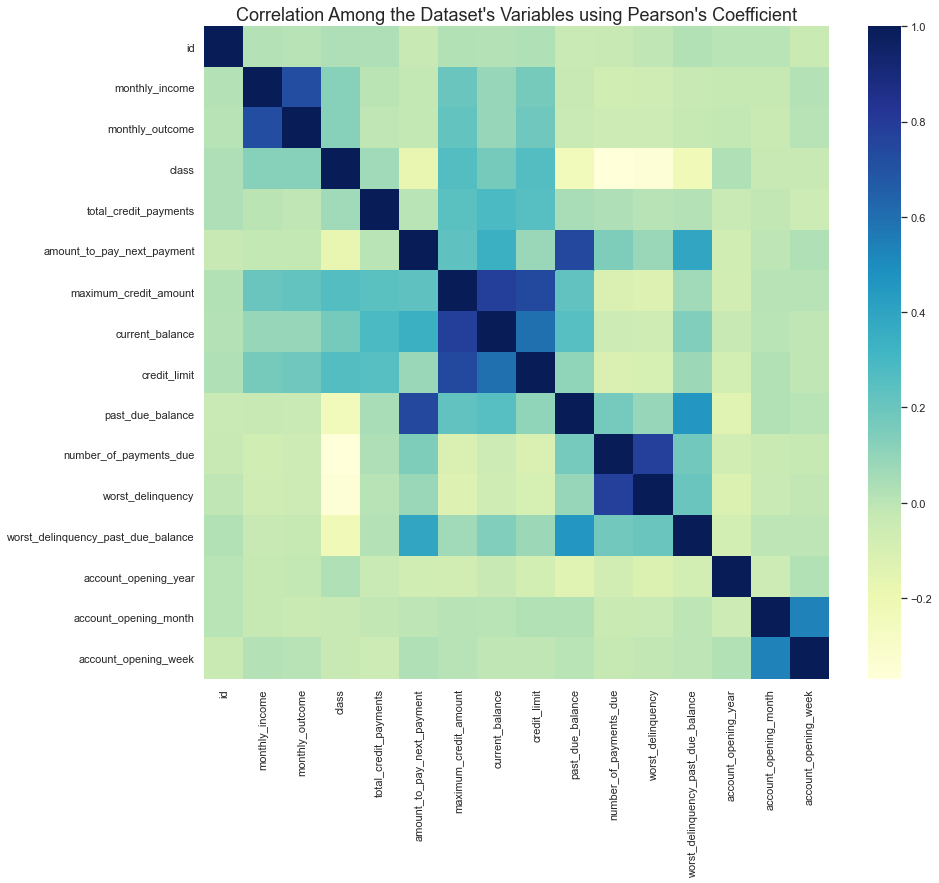

In [45]:
plt.figure(figsize=(14, 12))
p1 = sns.heatmap(data_merged.corr(), cmap="YlGnBu")
plt.title("Correlation Among the Dataset's Variables using Pearson's Coefficient", fontsize=18)
plt.margins(0.2)
fig = p1.get_figure()
fig.savefig("plots/07_correlation_among_variables.png")
plt.show()

We can see that the variables `monthly_income`, `monthly_outcome`, `maximum_credit_amount`, `current_balance`, `credit_limit`, have a relatively high correlation with the `class` variable. That is, if some of those variables increase, the `class` variable will also increase. On the other hand, there is a negative correlation with the following variables: `amount_to_pay_next_payment`, `past_due_balance`, `number_of_payments_due`, `worst_delinquency`, and `worst_delinquency_past_due_balance`

#### Mutual Information (MI)

In [46]:
"""
variables = ["id", "monthly_income", "monthly_outcome","class", "total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance", 
            'account_opening_year', 'account_opening_month',
       'account_opening_week']

data_merged[variables]
"""

'\nvariables = ["id", "monthly_income", "monthly_outcome","class", "total_credit_payments", \n                    "amount_to_pay_next_payment", "maximum_credit_amount", \n                    "current_balance", "credit_limit", "past_due_balance", \n                    "number_of_payments_due", "worst_delinquency",  \n                    "worst_delinquency_past_due_balance", \n            \'account_opening_year\', \'account_opening_month\',\n       \'account_opening_week\']\n\ndata_merged[variables]\n'

In [47]:
#pairwise2 = pairwise_corr(data[variables], drop_nan=True)

In [48]:
"""
plt.figure(figsize=(14, 12))
p1 = sns.heatmap(pairwise2, cmap="YlGnBu")
plt.title("Correlation Among the Dataset's Variables using Mutual Information", fontsize=18)
plt.margins(0.2)
fig = p1.get_figure()
sns.set_style("darkgrid")
fig.savefig("08_correlation_among_variables_mutual_information.png")
plt.show()
"""

'\nplt.figure(figsize=(14, 12))\np1 = sns.heatmap(pairwise2, cmap="YlGnBu")\nplt.title("Correlation Among the Dataset\'s Variables using Mutual Information", fontsize=18)\nplt.margins(0.2)\nfig = p1.get_figure()\nsns.set_style("darkgrid")\nfig.savefig("08_correlation_among_variables_mutual_information.png")\nplt.show()\n'

![CorrelationMutualInformation](plots/08.png)

### Treat the skewed variables

#### `data_users`

In [49]:
data_merged['monthly_income'] = np.log(data_merged['monthly_income'])
data_merged['monthly_outcome'] = np.log(data_merged['monthly_outcome'])

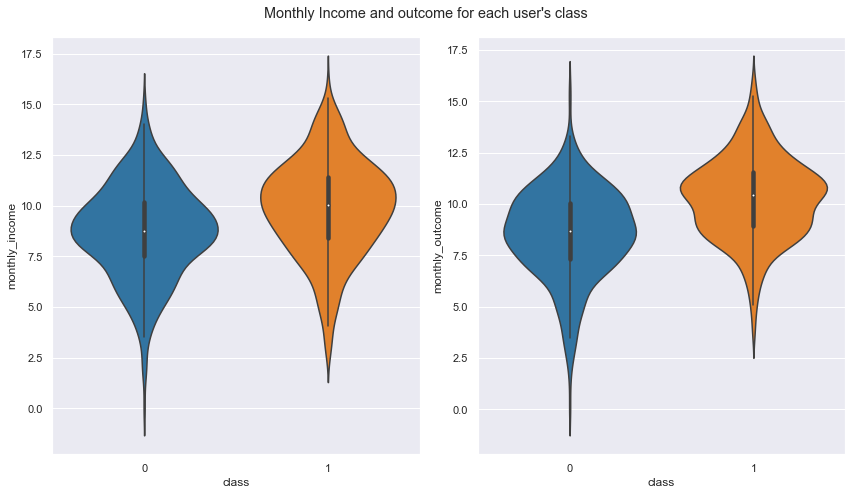

In [50]:
# Set up the matplotlib figure
sns.set_palette("tab10")
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)
fig.suptitle("Monthly Income and outcome for each user's class")

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_income', data=data_merged, showfliers=True, ax=axes[0])
#plt.show()

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_outcome', data=data_merged, showfliers=True, ax=axes[1])
#plt.show()

#axes1, axes2 = axes.ravel()
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 

#plt.setp(axes, yticks=[])
#fig = p1.get_figure()
fig.savefig("plots/09_datauser_skewed_after_treatment.png")
plt.tight_layout()

In [51]:
data_merged[['monthly_income', 'monthly_outcome']].skew().sort_values(ascending=False)

monthly_income    -0.264397
monthly_outcome   -0.332458
dtype: float64

`data_credit_reports`

In [52]:
variables = ["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]

data_merged[variables] = data_merged[variables] +1

In [53]:
# Log transform multiple columns in dataframe 
data_merged[variables] = data_merged[variables].apply(lambda x: np.log(x))

<ipython-input-54-b47eeb1b47e1>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_merged[["total_credit_payments",


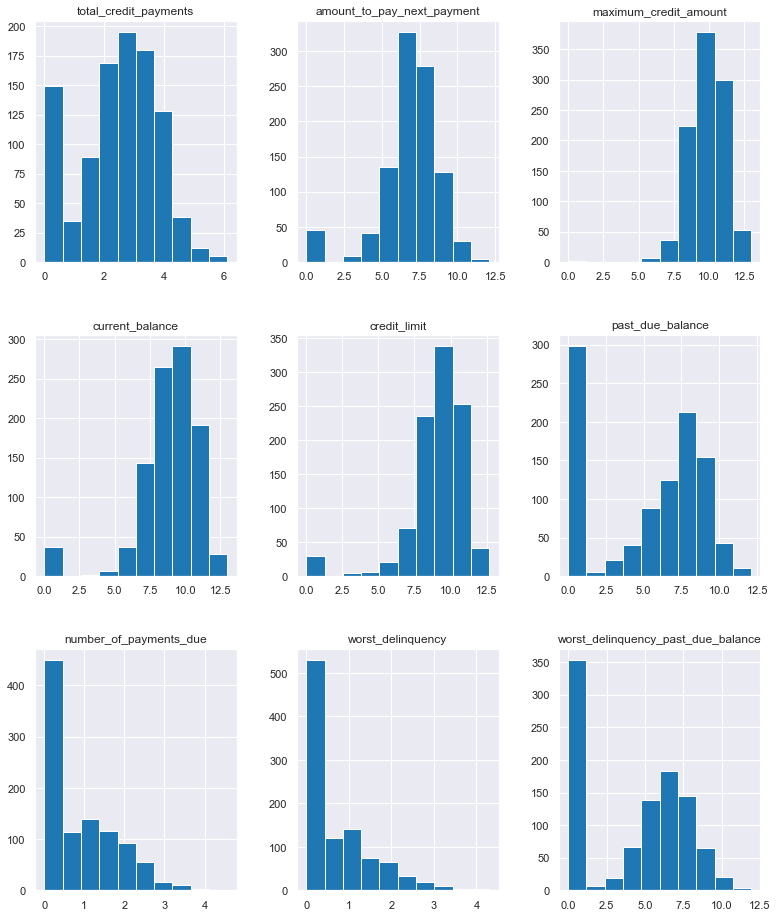

In [54]:
fig = plt.figure(figsize = (13,16))
ax = fig.gca()
#df.hist(ax = ax)
data_merged[["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]].hist(ax=ax)
#fig = p1.get_figure()
fig.savefig("plots/10_datacredit_reports_quantitative_variables_distribution_after_treatment.png")
plt.show()

In [55]:
variables = ["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]

data_merged[variables].skew().sort_values(ascending=False)

worst_delinquency                     1.295375
number_of_payments_due                0.816122
worst_delinquency_past_due_balance   -0.160485
total_credit_payments                -0.323603
past_due_balance                     -0.413872
maximum_credit_amount                -1.080572
amount_to_pay_next_payment           -1.542002
current_balance                      -2.070861
credit_limit                         -2.341017
dtype: float64

### Split the data

In [56]:
data_merged.columns

Index(['id', 'monthly_income', 'monthly_outcome', 'class',
       'total_credit_payments', 'amount_to_pay_next_payment',
       'maximum_credit_amount', 'current_balance', 'credit_limit',
       'past_due_balance', 'number_of_payments_due', 'worst_delinquency',
       'worst_delinquency_past_due_balance', 'institution_mod',
       'account_type_mod', 'credit_type_mod', 'payment_frequency_mod',
       'account_opening_year', 'account_opening_month',
       'account_opening_week'],
      dtype='object')

In [57]:
from sklearn.model_selection import StratifiedShuffleSplit

In [58]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
#for train_indices, test_indices in split.split(data_merged, data_merged[["class",  "credit_type_mod", "payment_frequency_mod"]]):
for train_indices, test_indices in split.split(data_merged, data_merged[["class",  "institution_mod", "payment_frequency_mod"]]):
    strat_train_set = data_merged.loc[train_indices]
    strat_test_set = data_merged.loc[test_indices]

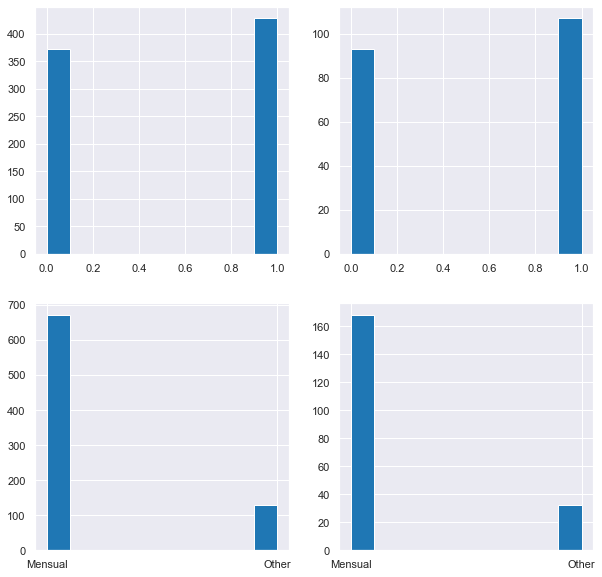

In [59]:
fig = plt.figure(figsize = (10,10))

plt.subplot(2,2, 1)
strat_train_set["class"].hist()
#strat_train_set["institution_mod"].hist()
#strat_train_set["credit_type_mod"].hist()
#strat_train_set["payment_frequency_mod"].hist()

plt.subplot(2, 2, 2)
strat_test_set["class"].hist()
#strat_test_set["institution_mod"].hist()
#strat_test_set["credit_type_mod"].hist()
#strat_test_set["payment_frequency_mod"].hist()

plt.subplot(2,2, 3)
strat_train_set["payment_frequency_mod"].hist()

plt.subplot(2,2, 4)

strat_test_set["payment_frequency_mod"].hist()
#fig = p1.get_figure()
fig.savefig("plots/11_sampling_train_test_sets.png")
plt.show()

### Encode the categorical variables and drop the useless variables

In [60]:
data_merged['credit_type_mod'].value_counts()

Línea de Crédito      318
Préstamo Personal     264
Tarjeta de Crédito    220
Other                 198
Name: credit_type_mod, dtype: int64

In [61]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Label enconder
        encoder_label = LabelEncoder()
        X["institution_enc"] = encoder_label.fit_transform(X[["institution_mod"]].values.ravel())
        
        # Label Binarizer
        encoder_binary = LabelBinarizer()
        X["payment_frequency_enc"] = encoder_binary.fit_transform(X[["payment_frequency_mod"]].values.ravel())
        
        #OneHot encoder
        encoder_onehot = OneHotEncoder()
        matrix = encoder_onehot.fit_transform(X[["account_type_mod"]].values.reshape(-1,1)).toarray()
        
        column_names = ["account_PF", "account_RE", "account_oth"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        
        matrix = encoder_onehot.fit_transform(X[['credit_type_mod']].values.reshape(-1,1)).toarray()
        
        column_names = ["cred_LC", "cred_PP", "cred_TC", "cred_oth"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

In [62]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["institution_mod", "payment_frequency_mod", "account_type_mod", 
                       "credit_type_mod", "id", "total_credit_payments", 
                      "account_opening_month", "account_opening_week"], axis=1, errors='ignore')

In [63]:
pipeline = Pipeline([('featureencoder', FeatureEncoder()),
                    ('featuredropper', FeatureDropper())])

#### Format the train and test sets

**Train sets**

In [64]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [65]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 761 to 212
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   monthly_income                      800 non-null    float64
 1   monthly_outcome                     800 non-null    float64
 2   class                               800 non-null    int64  
 3   amount_to_pay_next_payment          800 non-null    float64
 4   maximum_credit_amount               800 non-null    float64
 5   current_balance                     800 non-null    float64
 6   credit_limit                        800 non-null    float64
 7   past_due_balance                    800 non-null    float64
 8   number_of_payments_due              800 non-null    float64
 9   worst_delinquency                   800 non-null    float64
 10  worst_delinquency_past_due_balance  800 non-null    float64
 11  account_opening_year                800 non

**Test set**

In [66]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [67]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 491 to 62
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   monthly_income                      200 non-null    float64
 1   monthly_outcome                     200 non-null    float64
 2   class                               200 non-null    int64  
 3   amount_to_pay_next_payment          200 non-null    float64
 4   maximum_credit_amount               200 non-null    float64
 5   current_balance                     200 non-null    float64
 6   credit_limit                        200 non-null    float64
 7   past_due_balance                    200 non-null    float64
 8   number_of_payments_due              200 non-null    float64
 9   worst_delinquency                   200 non-null    float64
 10  worst_delinquency_past_due_balance  200 non-null    float64
 11  account_opening_year                200 non-

## Modeling

### Random Forests

In [68]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['class'], axis=1)
Y = strat_train_set['class']

scaler = StandardScaler()
X_data1 = scaler.fit_transform(X)

Y_data1 = Y.to_numpy() # we transform it because the X_data is a numpy array

In [69]:
X_test = strat_test_set.drop(["class"], axis=1)
y_test = strat_test_set['class']

scaler = StandardScaler()
X_data_test1 = scaler.fit_transform(X_test)
y_data_test1 = y_test.to_numpy()

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 

clf = RandomForestClassifier()

# the following hyperparameters will be used to build all the possible combinations and test them
param_grid = [
    {'n_estimators': [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data1, Y_data1)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [71]:
final_clf = grid_search.best_estimator_

In [72]:
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=200)

In [73]:
final_clf.score(X_data_test1, y_data_test1)

0.865

#### Selecting the most important features

In [74]:
print(final_clf.feature_importances_)
mask = final_clf.feature_importances_ > 0.1

[0.04932152 0.06089754 0.0568665  0.07479775 0.04652351 0.07383447
 0.1781973  0.09081931 0.15306191 0.1093405  0.02124306 0.02726077
 0.00555511 0.00513835 0.00318386 0.00516452 0.00816053 0.00306492
 0.00395975 0.02360882]


In [75]:
mask

array([False, False, False, False, False, False,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False])

In [76]:
final_data = pipeline.fit_transform(data_merged)
X = final_data.drop(["class"], axis=1)
y = final_data['class']

#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#y = y.to_numpy()

In [77]:
X_reduced = X.loc[:, mask]
print(X_reduced.columns)

Index(['past_due_balance', 'worst_delinquency',
       'worst_delinquency_past_due_balance'],
      dtype='object')


In [78]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=6, step=10, verbose=1)
rfe.fit(X_data1, Y_data1)

Fitting estimator with 20 features.
Fitting estimator with 10 features.


RFE(estimator=RandomForestClassifier(), n_features_to_select=6, step=10,
    verbose=1)

In [79]:
print(X.columns[rfe.support_])

Index(['maximum_credit_amount', 'credit_limit', 'past_due_balance',
       'number_of_payments_due', 'worst_delinquency',
       'worst_delinquency_past_due_balance'],
      dtype='object')


##### Second Model

In [80]:
X = strat_train_set.drop(['class'], axis=1)
Y = strat_train_set['class']

X = X[['maximum_credit_amount', 'credit_limit', 'past_due_balance',
       'number_of_payments_due', 'worst_delinquency',
       'worst_delinquency_past_due_balance']]

scaler = StandardScaler()
X_data2 = scaler.fit_transform(X)

Y_data2 = Y.to_numpy() # we transform it because the X_data is a numpu array

In [81]:
X_test = strat_test_set.drop(["class"], axis=1)
y_test = strat_test_set['class']

X_test = X_test[['maximum_credit_amount', 'credit_limit', 'past_due_balance',
       'number_of_payments_due', 'worst_delinquency',
       'worst_delinquency_past_due_balance']]

scaler = StandardScaler()
X_data_test2 = scaler.fit_transform(X_test)
y_data_test2 = y_test.to_numpy()

In [82]:
clf2 = RandomForestClassifier()

# the following hyperparameters will be used to build all the possible combinations and test them
param_grid = [
    {'n_estimators': [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(clf2, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data2, Y_data2)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [83]:
final_clf2 = grid_search.best_estimator_

In [84]:
final_clf2

RandomForestClassifier(min_samples_split=3, n_estimators=500)

In [85]:
final_clf2.score(X_data_test2, y_data_test2)

0.835

##### Third model

In [86]:
X = strat_train_set.drop(['class'], axis=1)
Y = strat_train_set['class']

X = X[['past_due_balance', 'worst_delinquency',
       'worst_delinquency_past_due_balance']]

scaler = StandardScaler()
X_data3 = scaler.fit_transform(X)

Y_data3 = Y.to_numpy() # we transform it because the X_data is a numpu array

In [87]:
X_test = strat_test_set.drop(["class"], axis=1)
y_test = strat_test_set['class']

X_test = X_test[['past_due_balance', 'worst_delinquency',
       'worst_delinquency_past_due_balance']]

scaler = StandardScaler()
X_data_test3 = scaler.fit_transform(X_test)
y_data_test3 = y_test.to_numpy()

In [88]:
clf3 = RandomForestClassifier()

# the following hyperparameters will be used to build all the possible combinations and test them
param_grid = [
    {'n_estimators': [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(clf3, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data3, Y_data3)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [89]:
final_clf3 = grid_search.best_estimator_

In [90]:
final_clf3.score(X_data_test3, y_data_test3)

0.81

---

### Logistic Regression

In [91]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['class'], axis=1)
Y = strat_train_set['class']

scaler = StandardScaler()
X_data1 = scaler.fit_transform(X)

Y_data1 = Y.to_numpy() # we transform it because the X_data is a numpy array

In [92]:
X_test = strat_test_set.drop(["class"], axis=1)
y_test = strat_test_set['class']

scaler = StandardScaler()
X_data_test1 = scaler.fit_transform(X_test)
y_data_test1 = y_test.to_numpy()

In [93]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_data1, Y_data1)
#y_pred = logreg.predict(X_test)

LogisticRegression()

In [94]:
logreg.score(X_data_test1, y_data_test1)

0.86

Coefficients

In [95]:
logreg.coef_[0]

array([ 0.24242617,  0.29761159, -0.88738675,  0.57483382,  0.76671232,
        0.21464084, -1.35119061, -0.22024934, -0.93387815, -0.1206412 ,
        0.04536787, -0.13646252, -0.21447149, -0.01000869, -0.03727323,
        0.05038928, -0.29775616, -0.0718025 , -0.02414548,  0.42503896])

In [96]:
dict(zip(X.columns, logreg.coef_[0]))

{'monthly_income': 0.24242617079054066,
 'monthly_outcome': 0.29761158701991464,
 'amount_to_pay_next_payment': -0.887386748165137,
 'maximum_credit_amount': 0.5748338170409794,
 'current_balance': 0.7667123219607694,
 'credit_limit': 0.21464084411455922,
 'past_due_balance': -1.3511906092085977,
 'number_of_payments_due': -0.22024934209719751,
 'worst_delinquency': -0.9338781491582093,
 'worst_delinquency_past_due_balance': -0.12064119989695703,
 'account_opening_year': 0.04536787182967224,
 'institution_enc': -0.13646251707439822,
 'payment_frequency_enc': -0.21447148574643518,
 'account_PF': -0.010008685076187077,
 'account_RE': -0.0372732275301548,
 'account_oth': 0.05038927503807559,
 'cred_LC': -0.29775616132866217,
 'cred_PP': -0.07180250492181048,
 'cred_TC': -0.024145479034208554,
 'cred_oth': 0.42503895991556945}

#### Selecting the most important features

In [97]:
pd.DataFrame.from_dict(dict(zip(X.columns, abs(logreg.coef_[0]))), orient='index').T

,monthly_income,monthly_outcome,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance,account_opening_year,institution_enc,payment_frequency_enc,account_PF,account_RE,account_oth,cred_LC,cred_PP,cred_TC,cred_oth
0,0.242426,0.297612,0.887387,0.574834,0.766712,0.214641,1.351191,0.220249,0.933878,0.120641,0.045368,0.136463,0.214471,0.010009,0.037273,0.050389,0.297756,0.071803,0.024145,0.425039


In [98]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=6, verbose=1)
rfe.fit(X_data1, Y_data1)

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.


RFE(estimator=LogisticRegression(), n_features_to_select=6, verbose=1)

In [99]:
X.columns[rfe.support_]

Index(['amount_to_pay_next_payment', 'maximum_credit_amount',
       'current_balance', 'past_due_balance', 'worst_delinquency', 'cred_oth'],
      dtype='object')

In [100]:
print(dict(zip(X.columns, rfe.ranking_)))

{'monthly_income': 5, 'monthly_outcome': 2, 'amount_to_pay_next_payment': 1, 'maximum_credit_amount': 1, 'current_balance': 1, 'credit_limit': 4, 'past_due_balance': 1, 'number_of_payments_due': 3, 'worst_delinquency': 1, 'worst_delinquency_past_due_balance': 9, 'account_opening_year': 12, 'institution_enc': 8, 'payment_frequency_enc': 6, 'account_PF': 15, 'account_RE': 13, 'account_oth': 10, 'cred_LC': 7, 'cred_PP': 11, 'cred_TC': 14, 'cred_oth': 1}


In [102]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_data_test1, rfe.predict(X_data_test1)))

0.865


##### Second model

In [103]:
X = strat_train_set.drop(['class'], axis=1)
Y = strat_train_set['class']

X = X[['amount_to_pay_next_payment', 'maximum_credit_amount',
       'current_balance', 'past_due_balance', 'worst_delinquency', 'cred_oth']]

scaler = StandardScaler()
X_data2 = scaler.fit_transform(X)

Y_data2 = Y.to_numpy() # we transform it because the X_data is a numpy array

In [104]:
X_test = strat_test_set.drop(["class"], axis=1)
y_test = strat_test_set['class']

X_test = X_test[['amount_to_pay_next_payment', 'maximum_credit_amount',
       'current_balance', 'past_due_balance', 'worst_delinquency', 'cred_oth']]

scaler = StandardScaler()
X_data_test2 = scaler.fit_transform(X_test)
y_data_test2 = y_test.to_numpy()

In [105]:
logreg2 = LogisticRegression()

logreg2.fit(X_data2, Y_data2)
#y_pred = logreg.predict(X_test)

LogisticRegression()

## Evaluation

### Random Forests

#### Validation

In [106]:
final_data = pipeline.fit_transform(data_merged)

In [107]:
X = final_data.drop(["class"], axis=1)
y = final_data['class']

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.to_numpy()

In [108]:
from sklearn.model_selection import cross_val_score

cv_scores_three_models = list()


cv_scores_three_models.append(cross_val_score(estimator=final_clf, X=X, y=y, cv=5, scoring='roc_auc').mean())

#print(cv_scores.mean())

In [109]:
X = final_data.drop(["class"], axis=1)
y = final_data['class']

X = X[['maximum_credit_amount', 'credit_limit', 'past_due_balance',
       'number_of_payments_due', 'worst_delinquency',
       'worst_delinquency_past_due_balance']]

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.to_numpy()

In [110]:
cv_scores_three_models.append(cross_val_score(estimator=final_clf2, X=X, y=y, cv=5, scoring='roc_auc').mean())

In [111]:
X = final_data.drop(["class"], axis=1)
y = final_data['class']

X = X[['past_due_balance', 'worst_delinquency',
       'worst_delinquency_past_due_balance']]

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.to_numpy()

In [112]:
cv_scores_three_models.append(cross_val_score(estimator=final_clf3, X=X, y=y, cv=5, scoring='roc_auc').mean())

In [113]:
cv_scores_three_models

[0.9345191438046427, 0.9240779821123505, 0.8939503567480657]

#### Confusion Matrix

In [114]:
y_predict = final_clf.predict(X_data_test1)

In [115]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_data_test1, y_predict))
print(classification_report(y_data_test1, y_predict))

[[77 16]
 [11 96]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        93
           1       0.86      0.90      0.88       107

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200



In [116]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_data_test1, y_predict))

0.865


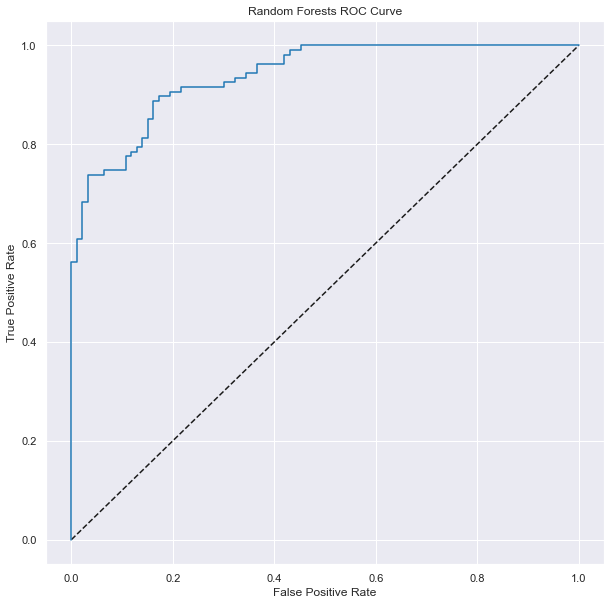

In [119]:
from sklearn.metrics import roc_curve
fig = plt.figure(figsize = (10,10))
y_pred_prob = final_clf.predict_proba(X_data_test1)[:,1]
fpr, tpr, thresholds = roc_curve(y_data_test1, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random Forests')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forests ROC Curve')
#fig = p1.get_figure()
fig.savefig("plots/12_random_forests_roc_curve.png")
plt.show();

#### Save the model

In [118]:
import pickle
# save the model to disk
filename = 'models/trained_model_random_forests.sav'
pickle.dump(final_clf, open(filename, 'wb'))
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Logistic Regression

#### Accuracy

In [120]:
logreg2.score(X_data_test2, y_data_test2)

0.865

In [123]:
X = strat_train_set.drop(['class'], axis=1)
Y = strat_train_set['class']
pd.DataFrame.from_dict(dict(zip(X.columns, abs(logreg2.coef_[0]))), orient='index').T

,monthly_income,monthly_outcome,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit
0,0.868459,0.840651,0.732996,1.391749,1.207662,0.745384


#### Confusion Matrix

In [124]:
y_pred = logreg2.predict(X_data_test2)

In [126]:
print(confusion_matrix(y_data_test2, y_pred))
print(classification_report(y_data_test2, y_pred))

[[80 13]
 [14 93]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        93
           1       0.88      0.87      0.87       107

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.87      0.86      0.87       200



Recall is also known as sensitivity, f1-score is the harmontic mean of precision and recall.
High precision: not many real events predicted as not event
High recall: predicted most positive events correctly

#### ROC curve

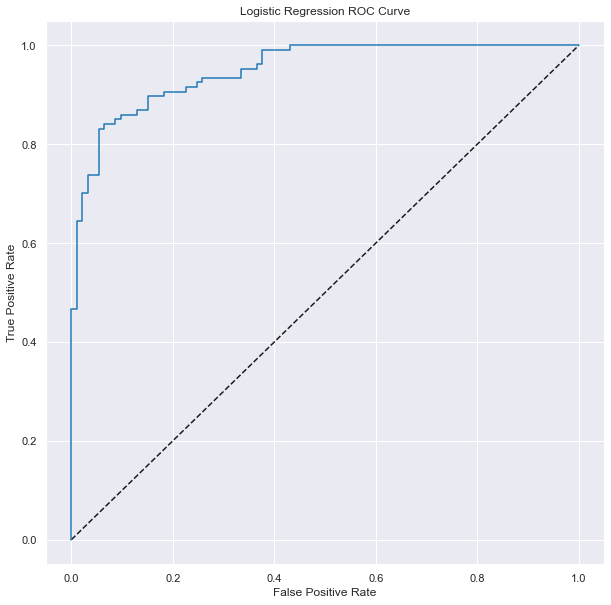

In [127]:
from sklearn.metrics import roc_curve
fig = plt.figure(figsize = (10,10))
y_pred_prob = logreg2.predict_proba(X_data_test2)[:,1]
fpr, tpr, thresholds = roc_curve(y_data_test2, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
#fig = p1.get_figure()
fig.savefig("plots/13_logistic_regression_roc_curve.png")
plt.show();

The area under the ROC curve is larger, so we can say that it is a good model

**Are under the ROC curve**

In [128]:
final_data = pipeline.fit_transform(data_merged)

In [129]:
X = final_data.drop(["class"], axis=1)
y = final_data['class']

X = X[['amount_to_pay_next_payment', 'maximum_credit_amount',
       'current_balance', 'past_due_balance', 'worst_delinquency', 'cred_oth']]

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.to_numpy()

In [130]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logreg2, X, y, cv=5, scoring='roc_auc')
print(cv_scores.mean())

0.9409506582253039


#### Save the model

In [131]:
import pickle
# save the model to disk
filename = 'models/trained_model_logistic_regression.sav'
pickle.dump(logreg2, open(filename, 'wb'))
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

#### Evaluating collinearity in Logistic Regression

In [132]:
#final_data.to_csv('processed_data/data_with_variables_encoded.csv', index=False)

In [133]:
X = final_data.drop(["class"], axis=1)
y = final_data['class']

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [135]:
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(X)

E:\Programas\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,monthly_income,1.799577
1,monthly_outcome,2.097022
2,amount_to_pay_next_payment,3.552870
3,maximum_credit_amount,2.674736
4,current_balance,4.294864
5,credit_limit,1.730276
6,past_due_balance,2.025603
7,number_of_payments_due,2.470802
8,worst_delinquency,3.591125
9,worst_delinquency_past_due_balance,2.892599


## Deployment

In [3]:
data_merged = pd.read_csv('processed_data/data_merged.csv')
final_data = pd.read_csv('processed_data/data_with_variables_encoded.csv')
analysis = data_merged.copy()

### Pick the best clients you will give a loan to, based on the model you created.  It could be as complex as you decide (even as simpler as knock out rules), as long as the metrics support it

In [4]:
import pickle
# load random forests
filename = 'models/trained_model_random_forests.sav'
final_clf = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
print(final_clf)

# load logistic regression
filename = 'models/trained_model_logistic_regression.sav'
logreg2 = pickle.load(open(filename, 'rb'))
print(logreg2)

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=200)
LogisticRegression()


In [5]:
from sklearn.preprocessing import StandardScaler
X = final_data.drop(["class"], axis=1)
y = final_data['class']

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.to_numpy()

In [6]:
mask_rf = final_clf.predict_proba(X)[:,1] > 0.90

In [8]:
best_customers_rf_data = analysis[mask_rf] 

#### Most important variables Random Forests

<ipython-input-38-f283e44a6acf>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  best_customers_rf_data[['maximum_credit_amount', 'credit_limit', 'past_due_balance',


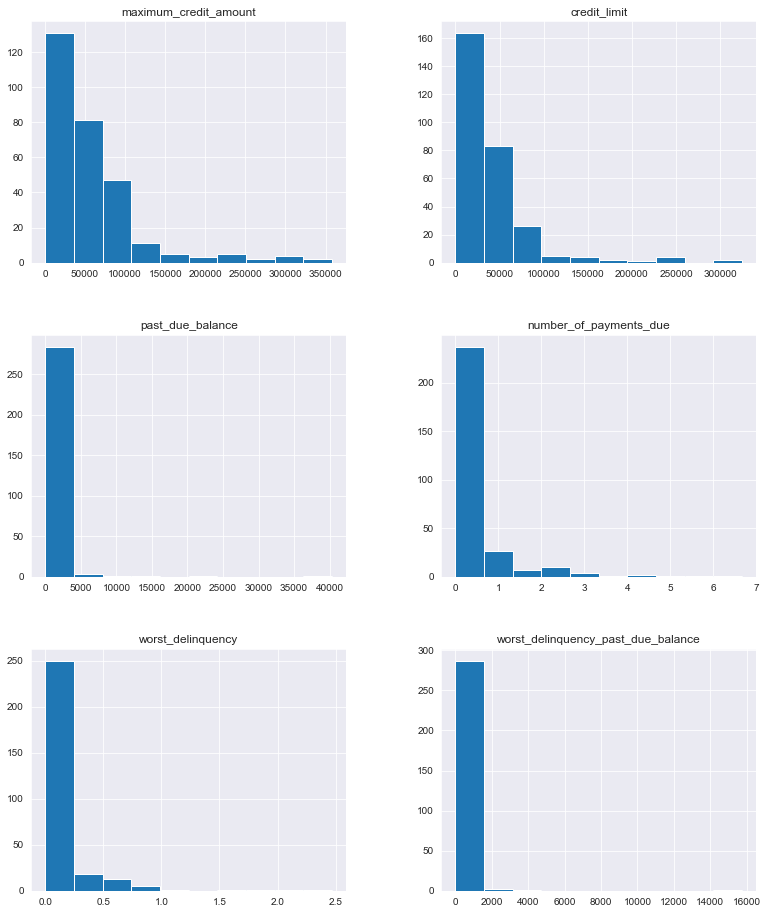

In [38]:
fig = plt.figure(figsize = (13,16))
sns.set_style("darkgrid")
ax = fig.gca()
#df.hist(ax = ax)
best_customers_rf_data[['maximum_credit_amount', 'credit_limit', 'past_due_balance',
       'number_of_payments_due', 'worst_delinquency',
       'worst_delinquency_past_due_balance']].hist(ax=ax)



#fig = p1.get_figure()
fig.savefig("plots/15_most_important_variables_best_customers_rf.png")
plt.show()

#### Most important Variables in Logistic Regression

In [30]:
X = final_data.drop(['class'], axis=1)
Y = final_data['class']

X = X[['amount_to_pay_next_payment', 'maximum_credit_amount',
       'current_balance', 'past_due_balance', 'worst_delinquency', 'cred_oth']]

In [12]:
mask_lr = logreg2.predict_proba(X)[:,1] > 0.999

In [13]:
best_customers_lr_data = analysis[mask_lr]

<ipython-input-39-4a0c9034cd2d>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  best_customers_lr_data[['amount_to_pay_next_payment', 'maximum_credit_amount',


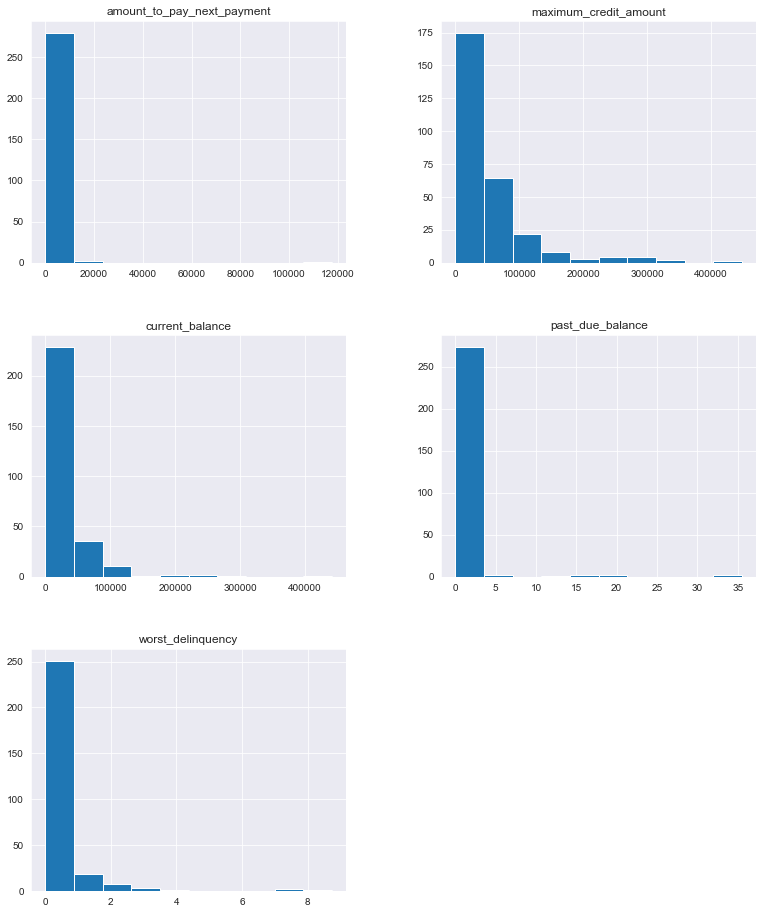

In [39]:
fig = plt.figure(figsize = (13,16))
sns.set_style("darkgrid")
ax = fig.gca()
#df.hist(ax = ax)
best_customers_lr_data[['amount_to_pay_next_payment', 'maximum_credit_amount',
       'current_balance', 'past_due_balance', 'worst_delinquency']].hist(ax=ax)

#fig = p1.get_figure()
fig.savefig("plots/16_most_important_variables_best_customers_lr.png")
plt.show()

#### Intersection between the best customers selected by each model

In [40]:
best_customers_rf = analysis[mask_rf]["id"].values

In [41]:
best_customers_lr = analysis[mask_lr]["id"].values

In [42]:
shared= np.intersect1d(best_customers_rf, best_customers_lr).shape[0]
best_rf = best_customers_rf.shape[0] - shared
best_lr = best_customers_lr.shape[0] - shared

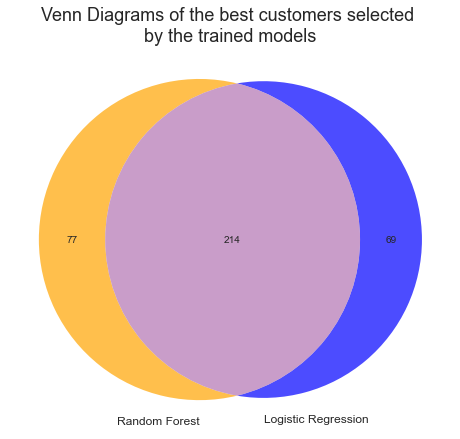

In [43]:
from matplotlib_venn import venn2 

fig = plt.figure(figsize = (8,8))
plt.title("Venn Diagrams of the best customers selected \nby the trained models", fontsize=18)
# depict venn diagram
venn2(subsets = ( best_rf, best_lr, shared), 
      set_labels = ('Random Forest', 'Logistic Regression'),
     set_colors=("orange", "blue"), alpha=0.7)
fig.savefig("plots/14_venn_diagramm_best_customers.jpg")
plt.show()

Given the trained models, we can calculate the best customers considering the high probability to do not having defaults. The Random Forest is more strict selecting customers because of having a lower cut-off it select a few customers.

### Propose an amount to be lended to those clients and a term in which the loan will need to be paid back

`monthly_income`, `monthly_outcome`	amount_to_pay_next_payment	maximum_credit_amount	current_balance	credit_limit

```r
library(MASS)
stepAIC(glm.fits, direciton='back')

model2 <- glm(formula = classes ~ monthly_outcome + amount_to_pay_next_payment + 
    maximum_credit_amount + current_balance + past_due_balance + 
    worst_delinquency + payment_frequency_enc + cred_LC + cred_PP + 
    cred_TC +credit_limit, family = binomial, data = data)
   
summary(model2)$coeff

#                              Estimate Std. Error   z value     Pr(>|z|)
#(Intercept)                -3.01248989 0.98597780 -3.055332 2.248112e-03
#monthly_outcome             0.19122818 0.05675373  3.369438 7.532156e-04
#amount_to_pay_next_payment -0.49116708 0.10463656 -4.694029 2.678759e-06
#maximum_credit_amount       0.64429538 0.12271793  5.250214 1.519227e-07
#current_balance             0.30338874 0.09608513  3.157500 1.591285e-03
#past_due_balance           -0.41412371 0.04707682 -8.796764 1.408183e-18
#worst_delinquency          -1.40659575 0.17891051 -7.862007 3.780261e-15
#payment_frequency_enc      -0.87163760 0.32355282 -2.693958 7.060914e-03
#cred_LC                    -1.86365336 0.34741691 -5.364314 8.125747e-08
#cred_PP                    -1.57789059 0.37447540 -4.213603 2.513291e-05
#cred_TC                    -1.35321889 0.37479162 -3.610590 3.055012e-04
#credit_limit                0.06414584 0.06196844  1.035137 3.006048e-01
```

In [33]:
dict(zip(X.columns, logreg2.coef_[0]))

{'amount_to_pay_next_payment': -0.8684590924858693,
 'maximum_credit_amount': 0.8406510255916457,
 'current_balance': 0.7329958650796538,
 'past_due_balance': -1.3917490236057908,
 'worst_delinquency': -1.2076620138062164,
 'cred_oth': 0.7453836326664676}

In [37]:
best_customers_rf_data[['maximum_credit_amount', 'credit_limit', 'past_due_balance',
       'number_of_payments_due', 'worst_delinquency',
       'worst_delinquency_past_due_balance']].describe()

,maximum_credit_amount,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000
mean,59109.121376,39576.550962,493.814262,0.424992,0.120854,137.892764
std,61865.761104,45997.167797,2900.161448,0.909531,0.292967,963.639413
min,467.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20683.715909,12275.000000,0.000000,0.000000,0.000000,0.000000
50%,41976.333333,27152.333333,0.000000,0.000000,0.000000,0.000000
75%,74343.940789,49793.250000,18.584559,0.444444,0.100000,72.472222
max,358189.000000,324718.238095,40361.400000,6.666667,2.470588,15748.525000


In [46]:
best_customers_lr_data[['amount_to_pay_next_payment', 'maximum_credit_amount',
       'current_balance', 'past_due_balance', 'worst_delinquency']].describe()

,amount_to_pay_next_payment,maximum_credit_amount,current_balance,past_due_balance,worst_delinquency
count,283.000000,283.000000,283.000000,283.000000,283.000000
mean,1431.928565,52072.004430,29081.437764,0.602387,0.337861
std,7106.402580,65286.491808,46328.138721,3.696477,0.982131
min,0.000000,233.500000,0.000000,0.000000,0.000000
25%,219.857143,12574.845238,4541.783333,0.000000,0.000000
50%,636.680000,30582.738095,14687.454545,0.000000,0.000000
75%,1120.897436,62500.719298,35916.484375,0.000000,0.172322
max,117606.000000,448307.000000,441894.000000,35.538462,8.750000


### Finally choose an anual interest rate the lended amount must have in order to be profitable